In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, cavi_lib
import vb_lib.structure_optimization_lib as s_optim_lib
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul

import paragami
import vittles

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib
from bnpmodeling_runjingdev.sensitivity_lib import get_jac_hvp_fun

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
autograd_results = np.load('./tmp.npz')

In [3]:
import numpy as onp
onp.random.seed(53453)

# Draw data

In [4]:
n_obs = 5
n_loci = 10
n_pop = 4

In [5]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

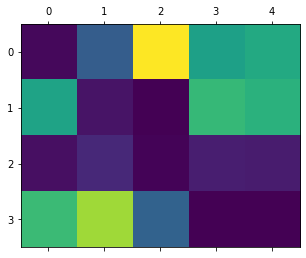

In [6]:
plt.matshow(true_ind_admix_propn.T)

In [7]:
g_obs = np.array(g_obs)

In [8]:
assert np.all(g_obs  == autograd_results['g_obs'])

# Get prior

In [9]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': DeviceArray([3.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


# Get VB params 

In [10]:
k_approx = 8

In [11]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [12]:
use_logitnormal_sticks = True

_, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (10, 8, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (5, 7) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (5, 7) (lb=0.0, ub=inf)


In [13]:
vb_params_free = autograd_results['vb_params_free']
vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)

assert np.all(vb_params_paragami.flatten(vb_params_dict, free = False) == \
              autograd_results['vb_params_flattened'])

# Define objective

In [14]:
stru_objective = s_optim_lib.StructureObjective(g_obs, 
                                                 vb_params_paragami,
                                                 prior_params_dict, 
                                                 gh_loc, gh_weights)

compiling objective ... 
done. Elasped: 80.6734


# Check gradients are the same as autograd

In [17]:
assert np.abs(stru_objective.f(vb_params_free) - \
              autograd_results['kl']) < 1e-8

In [18]:
assert np.abs(stru_objective.grad(vb_params_free) - \
              autograd_results['kl_grad']).max() < 1e-8

In [19]:
kl_hess = autograd_results['kl_hess']

for i in range(kl_hess.shape[0]): 
    
    e_i = onp.zeros(kl_hess.shape[0])
    e_i[i] = 1
    
    hvp1 = stru_objective.hvp(vb_params_free, e_i)
    hvp2 = np.dot(kl_hess, e_i)
    
    assert np.abs(hvp1 - hvp2).max() < 1e-8

In [20]:
import inspect
lines = inspect.getsource(stru_objective._kl_z2)
print(lines)

    def _kl_z2(self, vb_free_params, v): 
        
        # let "theta" be the vb free parameters
        # "moments" are the sufficient statistics of the vb params
        # "zeta" are **unconstrained** cluster belongings
        # "z" are **constrained** cluster belongings
        
        # "f_zz" is the hessian wrt to the z's
        
        # this method returns the second term of the schur complement: 
        # [dmoments/dtheta]^T[dzeta/dmoments]^T[dz/dzeta]^T ... 
        # [f_zz][dz/dzeta][dzeta/dmoments][dmoments/dtheta]
        
        
        # returns [dmoments/dtheta] v
        moments_tuple, moments_jvp = jax.jvp(self._get_moments_from_vb_free_params, \
                                             (vb_free_params, ), (v, ))
        
        # function that returns [dmoments/dtheta]^T v
        moments_vjp = jax.vjp(self._get_moments_from_vb_free_params, 
                              vb_free_params)[1]
        
        def scan_fun(val, x): 
            # x[0] is g_o